In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2025 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

# Jupyter notebook for: The impact of aerosol mixing state on immersion freezing: Insights from classical nucleation theory and particle-resolved simulations

### Wenhan Tang<sup>1</sup>, Sylwester Arabas<sup>2</sup>, Jeffrey H. Curtis<sup>1</sup>, Daniel A. Knopf<sup>3</sup>, Matthew West<sup>4</sup>, Nicole Riemer<sup>1</sup>
1. Department of Climate, Meteorology, and Atmospheric Sciences, University of Illinois Urbana-Champaign, Urbana, Illinois, USA
2. Faculty of Physics and Applied Computer Science, AGH University of Krakow, Kraków, Poland
3. School of Marine and Atmospheric Sciences, Stony Brook University, Stony Brook, New York, USA
4. Department of Mechanical Science and Engineering, University of Illinois Urbana-Champaign, Urbana, Illinois, USA


## Reproduce the Figures from Section 5 of the Paper

There are a total of 4*2=8 basic simulation groups, consisting of four types of INP populations and two temperature curve scenarios. The four types of INPs are 100% illite, 100% Fe2O3, a 50% illite and 50% Fe2O3 external mixture, and an internal mixture. The two temperature curves are a constant -20 degrees Celsius condition and a constant cooling rate condition from -10 to -30 degrees Celsius. The simulation time for each is 10 minutes. All immersion freezing simulations are using the ABIFM scheme.

exp1: 100% illite, constant temperature
exp2: 100% Fe2O3, constant temperature
exp3: external mixture, constant temperature
exp3: internal mixture, constant temperature
exp5: 100% illite, steady cooling
exp6: 100% Fe2O3, steady cooling
exp7: external mixture, steady cooling
exp8: internal mixture, steady cooling

There are a total of 2*9 additional simulations, consisting of nine types of Fe2O3–illite mixed INPs with different mixing states $\chi$ = 10\%, 20\%, 30\%, 40\%, 50\%, 60\%, 70\%, 80\%, 90\%. Each type is simulated under two conditions: (i) a constant temperature of -20 degress Celsius, and (ii) a constant cooling rate from -10 to -30 degress Celsius.


In this notebook, all the simulation experiments are conducted with PyPartMC (https://github.com/open-atmos/PyPartMC.git).

**Please note the outputs generated by this notebook may not be identical to those reported in the paper, since the PartMC model employs stochastic algorithms, which can lead to run-to-run variability in the results. This variability is particularly pronounced when the number of computational particles (N_PART) and the number of ensemble realizations (n_ensemble) are relatively small.**

In [2]:
# Install and import PyPartMC
try:
    import PyPartMC as ppmc
    from PyPartMC import si
except ImportError:
    !pip install git+https://github.com/slayoo/PyPartMC.git@freezing
    import PyPartMC as ppmc
    from PyPartMC import si
try:
    from open_atmos_jupyter_utils import show_plot
except ImportError:
    !pip install open_atmos_jupyter_utils
    from open_atmos_jupyter_utils import show_plot

In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.interpolate import interp1d
from scipy.integrate import quad

# Function for single experiment (default settings)

In [4]:
def run_experiment(*,
    N_PART = 2000,
    time_timeseries = (0, 600),
    temp_timeseries = (263.150, 243.150),
    AERO_DIST_INIT,
    hist_output_time = None,
    N_bins_output = 50,
    weight_type = "flat",
    mixing_state_modifier = None,
):

    if hist_output_time is None:
        hist_output_time = []
    gas_data = ppmc.GasData(("SO2",))
    aero_data = ppmc.AeroData(
        (
            #         density  ions in soln (1) molecular weight    kappa (1)   ABIFM (m) ABIFM (c)
            #         |                       |  |                       |      |         |
            {"H2O":  [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol,   0.00,  0,        0]},
            {"ILT":  [2700 * si.kg / si.m**3, 0, 389.34 * si.g / si.mol, 0.003, 54.48075, -10.66873]},
            {"Fe2O3":[5240 * si.kg / si.m**3, 0, 159.69 * si.g / si.mol, 0.01,  17.62106, 1.42411]},
        )
    )
    gas_state = ppmc.GasState(gas_data)

    gas_state.mix_rats = (
        {"SO2": [0.0E+00]},
    )
    AERO_DIST_EMIT = {
        "gasoline": {
            "mass_frac": [{"H2O": [1.0]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0 / si.m**3,
            "geom_mean_diam": 5e-8 * si.m,
            "log10_geom_std_dev": 0.24,
        },
    }

    aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

    gas_emit_times = [0]
    gas_emit_rates = np.zeros(len(gas_emit_times))
    emit_gas = [
        {"time": gas_emit_times},
        {"rate": list(gas_emit_rates)},
        {"SO2": [0]},
    ]
    env_state = ppmc.EnvState(
        {
            "rel_humidity": 1.00,
            "latitude": 0,
            "longitude": 0,
            "altitude": 0 * si.m,
            "start_time": 21600 * si.s,
            "start_day": 200,
        }
    )
    pressure_timeseries = [50000.0, 50000.0]
    height_timeseries = [1000, 1000]
    AERO_DIST_BACKGROUND = {
        "back_small": {
            "mass_frac": [{"H2O": [0.76595745]}, {"ILT": [0.23404255]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0 / si.m**3,
            "geom_mean_diam": 0.02 * si.um,
            "log10_geom_std_dev": 0.161,
        },
    }
    times = [0 * si.s]
    back_gas = [{"time": times},
                {"rate": [0.0 / si.s]},
                {"SO2": [0.0E+00]},
               ]
    scenario = ppmc.Scenario(
        gas_data,
        aero_data,
        {
            "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
            "pressure_profile": [
                {"time": time_timeseries},
                {"pressure": pressure_timeseries},
            ],
            "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
            "gas_emissions": emit_gas,
            "gas_background": back_gas,
            "aero_emissions": [
                {"time": [0 * si.s, 12 * 3600 * si.s]},
                {"rate": [1 / si.s, 0 / si.s]},
                {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
            ],
            "aero_background": [
                {"time": [0 * si.s]},
                {"rate": [1.5e-5 / si.s]},
                {"dist": [[AERO_DIST_BACKGROUND]]},
            ],
            "loss_function": "none",
        },
    )
    T_INITIAL = 0.0
    scenario.init_env_state(env_state, T_INITIAL)
    run_part_opt = ppmc.RunPartOpt(
        {
            "output_prefix": "freezing",
            "do_coagulation": False,
            "do_immersion_freezing": True,
            "immersion_freezing_scheme": "ABIFM",
            "t_max": 600 * si.s,
            "t_output": 600 * si.s,
            "del_t": 1 * si.s,
        }
    )
    #aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
    aero_state = ppmc.AeroState(aero_data, N_PART, weight_type)
    aero_state.dist_sample(
        aero_dist_init,
        sample_prop=1.0,
        create_time=0.0,
        allow_doubling=True,
        allow_halving=True,
    )
    if mixing_state_modifier is not None:
        aero_state, _ = mixing_state_modifier.modify(aero_state, aero_data)

    camp_core = ppmc.CampCore()
    photolysis = ppmc.Photolysis()
    N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
    time_ = np.zeros(N_STEPS + 1)
    num_conc = np.zeros(N_STEPS + 1)
    frozen_frac = np.zeros(N_STEPS + 1)
    num_conc[0] = aero_state.total_num_conc
    height = np.zeros((N_STEPS + 1))
    temperature = np.zeros((N_STEPS + 1))
    rh = np.zeros((N_STEPS + 1))

    height[0] = env_state.height
    temperature[0] = env_state.temp
    rh[0] = env_state.rh
    
    # special variables for output
    dry_diameter_hist = {}
    frozen_dry_diameter_hist = {}
    
    last_output_time = 0.
    last_progress_time = 0.
    i_output = 1

    for i_time in range(1, N_STEPS + 1):
        (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
            scenario,
            env_state,
            aero_data,
            aero_state,
            gas_data,
            gas_state,
            run_part_opt,
            camp_core,
            photolysis,
            i_time,
            T_INITIAL,
            last_output_time,
            last_progress_time,
            i_output
        )
        num_conc[i_time] = aero_state.total_num_conc
        frozen_frac[i_time] = aero_state.frozen_fraction
        time_[i_time] = env_state.elapsed_time
        height[i_time] = env_state.height
        temperature[i_time] = env_state.temp
        
        if int(env_state.elapsed_time) in hist_output_time:
            dry_diameter_hist[int(env_state.elapsed_time)] = np.histogram(
                np.log10(aero_state.dry_diameters),
                weights=aero_state.num_concs,
                bins = N_bins_output
            )
            frozen_num_concs = np.array(
                [
                    aero_state.num_concs[i_part] \
                        * aero_state.particle(i_part).is_frozen \
                        for i_part in range(len(aero_state))
                ]
            )
            frozen_dry_diameter_hist[int(env_state.elapsed_time)] = np.histogram(
                np.log10(aero_state.dry_diameters),
                weights=frozen_num_concs ,
                bins = N_bins_output
            )
            
    return {
        "num_conc": num_conc,
        "frozen_frac": frozen_frac,
        "time": time_,
        "height": height,
        "temperature": temperature,
        "dry_diameter_hist": dry_diameter_hist,
        "frozen_dry_diameter_hist": frozen_dry_diameter_hist,
    }

# Function for ensemble run

In [5]:
def run_experiment_ensemble(n_ensemble, special_variable_for_first_ensemble, **kwargs):
    
    experiment_ensemble_output = {}
    
    for i_ensemble in range(n_ensemble):
        experiment_output_i = run_experiment(
            **kwargs,
            **(special_variable_for_first_ensemble if i_ensemble == 0 else {})
        )
        for varName, var_value in experiment_output_i.items():
            if varName not in experiment_ensemble_output: 
                if isinstance(var_value, np.ndarray):
                    experiment_ensemble_output[varName] = np.full(
                        (n_ensemble, ) + var_value.shape, np.nan)
                else:
                    experiment_ensemble_output[varName] = []
            
            if isinstance(var_value, np.ndarray):
                experiment_ensemble_output[varName][i_ensemble, :] = var_value[:]
            else:
                experiment_ensemble_output[varName].append(var_value)

    return experiment_ensemble_output

# Function for converting species volume ratio to mass ratio

In [6]:
# The density of each species
dens_data = {
    "H2O": 1000 * si.kg / si.m**3,
    "OIN": 2600 * si.kg / si.m**3,
    "ILT": 2750 * si.kg / si.m**3,
    "Al2O3": 3970 * si.kg / si.m**3,
    "Fe2O3": 5240 * si.kg / si.m**3,
    "KLN": 2650 * si.kg / si.m**3,
}

def volume_to_mass(volume_ratio, D_dry = None):
    # Convert the species volume ratio to mass ratio,
    # and calculate the wet diameter of a droplet.
    
    volume_ratio_list = []
    dens_list = []
    iH2O = None
    
    for ind, species in enumerate(volume_ratio):
        assert species in dens_data
        if species == "H2O":
            iH2O = ind
        volume_ratio_list.append(volume_ratio[species])
        dens_list.append(dens_data[species])
    dens_list = np.array(dens_list)
    volume_ratio_list = np.array(volume_ratio_list)
    volume_ratio_list = volume_ratio_list / np.sum(volume_ratio_list)
    mass_ratio_list = volume_ratio_list * dens_list
    mass_ratio_list = mass_ratio_list / np.sum(mass_ratio_list)
    
    if D_dry is None:
        D_wet = None
    else:
        if (iH2O is None) or volume_ratio["H2O"] == 0.0:
            D_wet = D_dry
        else:
            Vdry = 1/6 * np.pi * D_dry**3
            H2O_vratio = volume_ratio_list[iH2O]
            nuclei_vratio = np.sum(
                volume_ratio_list[np.arange(len(volume_ratio_list)) != iH2O]
            )
            assert H2O_vratio + nuclei_vratio == 1.0
            Vwet = Vdry / nuclei_vratio 
            D_wet = (Vwet * 6 / np.pi) ** (1.0/3)
            
    mass_ratio_dict = {}
    for ind, species in enumerate(volume_ratio):
        mass_ratio_dict[species] = mass_ratio_list[ind]
        
    return mass_ratio_dict, D_wet


# Experiments settings

In [7]:
# The geometric mean of dry diameter
# (set to 1 µm to reproduce the experiments in the paper).
Dpg = 1*si.um

# The log-geometric standard deviation of dry diameter
# (set to 0.5 to reproduce the experiments in the paper).
logStd = 0.5

# The total pariticle number concentration
# (set to 100cm^-3 to reproduce the experiments in the paper).
Nt = 100 / si.cm**3

# Get the size distribution density function of activated INPs at these time points
# (set to [120, 300, 540] to reproduce the figure 7 in the paper).
time_steps_for_hist_output = [120, 300, 540]

# The bin number for the size distribuition density function mentioned above 
# (set to 50 to reproduce the figure 7 in the paper).
Nbins_for_bin_plots = 50

# Temperature setting for "constant temperature" conditions (-20˚C).
temp_constant_temperature = {
    "time_timeseries": (0, 600),
    "temp_timeseries": (253.150, 253.150),
}

# Temperature setting for "constant cooling rate" conditions (-2˚C/min).
temp_constant_cooling_rate = {
    "time_timeseries": (0, 600),
    "temp_timeseries": (263.150, 243.150),
}

# Pure illite (immersed in water)
mass_ratio, Dwet = volume_to_mass(volume_ratio = {"H2O": 0.9, "ILT": 0.1}, D_dry = Dpg)
#print("Dp_wet = ", Dwet, "H2O = ", mass_ratio["H2O"], "Fe2O3 = ", mass_ratio["ILT"])
aero_dist_illite = [
    {
        "init_illite": {
            "mass_frac": [{"H2O": [mass_ratio["H2O"]]}, {"ILT": [mass_ratio["ILT"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": Nt,
            "geom_mean_diam": Dwet,
            "log10_geom_std_dev": logStd,
        },
    }
]

# Pure Fe2O3 (immersed in water)
mass_ratio, Dwet = volume_to_mass(volume_ratio = {"H2O": 0.9, "Fe2O3": 0.1}, D_dry = Dpg)
aero_dist_Fe2O3 = [
    {
        "init_Fe2O3": {
            "mass_frac": [{"H2O": [mass_ratio["H2O"]]}, {"Fe2O3": [mass_ratio["Fe2O3"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": Nt,
            "geom_mean_diam": Dwet,
            "log10_geom_std_dev": logStd,
        },
    }
]

# External mixture (surface ratio 50:50, immersed in water)
mass_ratio_1, Dwet_1 = volume_to_mass(volume_ratio = {"H2O": 0.9, "Fe2O3": 0.1}, D_dry = Dpg)
mass_ratio_2, Dwet_2 = volume_to_mass(volume_ratio = {"H2O": 0.9, "ILT": 0.1}, D_dry = Dpg)
aero_dist_external = [
    {
        "init_Fe2O3": {
            "mass_frac": [{"H2O": [mass_ratio_1["H2O"]]}, {"Fe2O3": [mass_ratio_1["Fe2O3"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": Nt * 0.5,
            "geom_mean_diam": Dwet_1,
            "log10_geom_std_dev": logStd,
        },
        "init_illite": {
            "mass_frac": [{"H2O": [mass_ratio_2["H2O"]]}, {"ILT": [mass_ratio_2["ILT"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": Nt * 0.5,
            "geom_mean_diam": Dwet_2,
            "log10_geom_std_dev": logStd,
        },
    }
]

#Internal mixture (surface ratio 50:50, immersed in water)
mass_ratio, Dwet = volume_to_mass(
    volume_ratio = {"H2O": 0.9, "Fe2O3": 0.05, "ILT": 0.05},
    D_dry = Dpg
)

aero_dist_internal = [
    {
        "init_Fe2O3_illite": {
            "mass_frac": [
                {"H2O": [mass_ratio["H2O"]]},
                {"Fe2O3": [mass_ratio["Fe2O3"]]},
                {"ILT": [mass_ratio["ILT"]]}
            ],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": Nt,
            "geom_mean_diam": Dwet,
            "log10_geom_std_dev": logStd,
        },
    }
]

variable_for_first_ensemble = {
        "hist_output_time": time_steps_for_hist_output,
        "N_bins_output": Nbins_for_bin_plots,
}

exps_settings_PartMC = {}
expID = 1
temp_profile_list = [
    temp_constant_temperature,
    temp_constant_cooling_rate
]
aero_dist_list = [
    aero_dist_illite,
    aero_dist_Fe2O3,
    aero_dist_external,
    aero_dist_internal
]
for temp_setting in temp_profile_list:
    for aero_dist_setting in aero_dist_list:
        exps_settings_PartMC["exp%d" % (expID)] = {
            **temp_setting, 
            "special_variable_for_first_ensemble": variable_for_first_ensemble, 
            "AERO_DIST_INIT": aero_dist_setting,
        }
        expID += 1

# Run experiments

In [8]:
experiments_output = {}

for case_name, exp_setting in exps_settings_PartMC.items():
    print("Running PartMC for " + case_name + " ...")
    experiments_output[case_name] = run_experiment_ensemble(
        N_PART = 5000,
        n_ensemble = 10,
        **exp_setting
    )

Running PartMC for exp1 ...
Running PartMC for exp2 ...
Running PartMC for exp3 ...
Running PartMC for exp4 ...
Running PartMC for exp5 ...
Running PartMC for exp6 ...
Running PartMC for exp7 ...
Running PartMC for exp8 ...


# Theoretical frozen fraction calculation for each experiment


The size distribution density function of activated INPs is
\begin{equation}
    n_\text{frz}(t,\ \ln D_\text{p})=\frac{\tilde{N}_\text{t}}{\sqrt{2\pi}\cdot \ln \sigma_\text{g}}e^{-\frac{{(\ln D_\text{p}-\ln {\bar{D}}_{\text{pg}})}^2}{2{\ln }^2\sigma_\text{g}}}\cdot(1-e^{-\pi D_\text{p}^2\cdot\bar{\Phi}(t)}).\ (B10)
\end{equation}

The ice number concentration is calculated by:
\begin{equation}
    \tilde{N}_{\text{frz}}(t)=\tilde{N}_\text{t}-\frac{\tilde{N}_\text{t}}{\sqrt{2\pi}\cdot \ln  \sigma_\text{g}}\cdot\int_{-\infty}^{+\infty}{\exp\left[-\frac{{(\ln  D_\text{p}-\ln  {\bar{D}}_{\text{pg}})}^2}{2{\ln }^2\sigma_\text{g}}-\pi D_\text{p}^2\cdot\bar{\Phi}(t)\right]d\ln  D_\text{p}}. \ (B11)
\end{equation}

The frozen fraction is calculated by:
\begin{equation}
    f_{\text{frz}}=\tilde{N}_{\text{frz}}(t)/\tilde{N}_\text{t}, \ (B8)
\end{equation}
or combining Eqs. (B8) and (B11):

\begin{equation}
    f_{\text{frz}}(t)=1-\frac{1}{\sqrt{2\pi}\cdot \ln  \sigma_\text{g}}\cdot\int_{-\infty}^{+\infty}{\exp\left[-\frac{{(\ln  D_\text{p}-\ln {\bar{D}}_{\text{pg}})}^2}{2{\ln }^2\sigma_\text{g}}-\pi D_\text{p}^2\cdot\bar{\Phi}(t)\right]d\ln  D_\text{p}}.\ (B12)
\end{equation}

In [9]:
species_ABIFM_params = {
    # ABIFM parameters. Derived from Knopf and Alpert (2013).
    "N. atomus": {"m": 83.95603, "c": -17.12381},
    "T. pesudonana": {"m": 59.66992, "c": -10.43450},
    "Pahokee Peat": {"m": 78.30951, "c": -15.77884},
    "Leonardite": {"m": 66.90259, "c": -13.40148},
    "Illite": {"m": 54.48075, "c": -10.66873},
    "1-Nonadecanol": {"m": 28.13797, "c": -2.92414},
    "Kaolinite": {"m": 54.58834, "c": -10.54758},
    "Al2O3": {"m": 14.96639, "c": 1.60671},
    "Fe2O3": {"m": 17.62106 , "c": 1.42411},
    "Fungal Spores": {"m": 15.47856, "c": 0.97931},
    "dust": {"m": 22.62, "c": -1.35},
}

def compute_e_s(T):
    # Calculation of saturated vapor pressure w.r.t. water.
    tmp =  54.842763 - 6763.22 / T - 4.210 * np.log(T) \
            + 0.000367 * T + np.tanh( 0.0415 * (T - 218.8)) \
            * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T)
    pvs = np.exp(tmp)
    return pvs

def compute_e_si(T):
    # Calculation of saturated vapor pressure w.r.t. ice.
    tmp = 9.550426 - 5723.265 / T + 3.53068 * np.log(T) - 0.00728332 * T
    pis = np.exp(tmp)
    return pis


def water_activity(T, RH):
    # Calculation of water activity (w.r.t. water and ice)
    # by assuming RH = 100%.
    e_s = compute_e_s(T)
    e_si = compute_e_si(T)
    aw = RH / 100
    aw_ice = e_si / e_s
    delta_aw = aw - aw_ice
    return aw, aw_ice, delta_aw

def ABIFM(T, m, c):
    # Calculation of the log10 J_het for species with 
    # given m and c parametersunder specific temperature T.
    
    # Calculate the water activity.
    _, _, delta_aw = water_activity(T, 100)
    
    # Eq. (20) -> The ABIFM model for Jhet calculation. 
    # (Knopf and Alpert, 2013)
    log10_J_het = (m * delta_aw + c)
    return log10_J_het

class DensityFunctionFrozen():
    """ Density function for activated ice-nucleating particles (INPs).

    Computes the log10(Dp) distribution density (Eq. B10) given freezing 
    probability `Phi`, total number `N_total`, mean diameter `D_pg`, 
    and geometric std `log_Std`. Callable via `density()` or directly.
    
    """
    def __init__(self, Phi, N_total, D_pg, log_Std):
        self.Phi = Phi
        self.N_total = N_total
        self.D_pg = D_pg
        self.log_Std = log_Std
        
    def density(self, log10_Dp):
        # The Eq. (B10) -> log10(Dp) distribution 
        # density function for activated INPs.
        return self.N_total / (np.sqrt(2 * np.pi) * self.log_Std) \
            * np.exp( -(log10_Dp - np.log10(self.D_pg)) **2 \
            / (2 * self.log_Std **2)) \
            * (1 - np.exp(- np.pi*self.Phi*(10**log10_Dp) **2))
        
    def __call__(self, *args):
        return self.density(*args)

class DensityFunctionUnfrozen():
    """ Density function for unactivated ice-nucleating particles (INPs).

    Computes the log10(Dp) distribution density (Eq. B10) given freezing 
    probability `Phi`, total number `N_total`, mean diameter `D_pg`, 
    and geometric std `log_Std`. Callable via `density()` or directly.
    
    """
    def __init__(self, Phi, N_total, D_pg, log_Std):
        self.Phi = Phi
        self.N_total = N_total
        self.D_pg = D_pg
        self.log_Std = log_Std
        
    def density(self, log10_Dp):
        return self.N_total / (np.sqrt(2 * np.pi) * self.log_Std) \
            * np.exp( -(log10_Dp - np.log10(self.D_pg)) **2 \
            / (2 * self.log_Std **2) - np.pi*self.Phi*(10**log10_Dp) **2)
        
    def __call__(self, *args):
        return self.density(*args)

def theoretical_frozen_fraction(
        time_timeseries,
        temp_timeseries,
        D_pg, log_Std, N_total,
        species_ratio_dict, 
        func_frz_dens_timepoints = None
    ):
    # Calculating the theoretical frozen fraction and size 
    # distribution density function of activated INPs for
    # single-mode INP population.
    
    if func_frz_dens_timepoints is None:
        func_frz_dens_timepoints = []
        
    # Convert the time resolution to 1 s.
    timeList_ = np.arange(time_timeseries[0], time_timeseries[-1] + 1, 1)
    tempList_ = np.full( (len(timeList_)), np.nan )
    index_ = np.array([np.argmin(np.abs(timeList_ - time)) for time in time_timeseries])
    ff = interp1d(time_timeseries, temp_timeseries)
    tempList_ = ff(timeList_)

    species_name = []
    species_ratio = []
    for specName, specRatio in species_ratio_dict.items():
        species_name.append(specName)
        species_ratio.append(specRatio)

    species_ratio = species_ratio / np.sum(species_ratio)
    Phi = 0
    time = 0
    logDp1 = np.log10(D_pg) - 9 * log_Std
    logDp2 = np.log10(D_pg) + 9 * log_Std
    dt = np.mean(timeList_[1:] - timeList_[:-1])
    ice_ratio_list = [0]
    ice_numconc_list = [0]
    func_frz_dens_dict = {}
    
    # Calculation is applied to each time step.
    for time, T in zip(timeList_[1:], tempList_[1:]):
        # Compute the surface weighted Phi value by integrating
        # surface weighted Jhet over time, according to Eq. (6) and (8).
        Jhet = 0
        for specName, specRatio in zip(species_name, species_ratio):
            abifm_m = species_ABIFM_params[specName]["m"]
            abifm_c = species_ABIFM_params[specName]["c"]
            Jhet_spec = 10 **ABIFM(T, abifm_m, abifm_c) * 10000
            Jhet += Jhet_spec * specRatio

        Phi += Jhet * dt
        
        # The Eq.(B11) -> The ice number concentration 
        # is calculated by the following three steps:
        
        # 1. Define the log10(Dp) distribution density function for unactivated INPs;
        func_unf_dens = DensityFunctionUnfrozen(Phi, N_total, D_pg, log_Std)
        
        # 2. Calculate the number concentration of unactivate INPs;
        unf_numc, _ = quad(func_unf_dens, logDp1, logDp2)
        
        # 3. Calcuate the ice number concentration.
        frz_numc = N_total - unf_numc
        
        # The Eq. (B8) -> The frozen fraction.
        ice_ratio = frz_numc / N_total
        
        ice_ratio_list.append(ice_ratio)
        ice_numconc_list.append(frz_numc)
        
        if int(time) in func_frz_dens_timepoints:
            
            # log10(Dp) distribution density function for activated INPs.
            func_frz_dens_dict[int(time)] = \
                DensityFunctionFrozen(Phi, N_total, D_pg, log_Std)
            
    ice_ratio_list = np.array(ice_ratio_list)
    ice_numconc_list = np.array(ice_numconc_list)
    

    ice_ratio_list = ice_ratio_list[index_]
    ice_numconc_list = ice_numconc_list[index_]

    return {
        "frozen_frac": ice_ratio_list,
        "ice_numconc": ice_numconc_list,
        "frz_dens": func_frz_dens_dict,
    }

def theoretical_frozen_fraction_multimodal(time_timeseries, temp_timeseries, modes_setting_list):
    # Calculating the theoretical frozen fraction and size 
    # distribution density function of activated INPs
    # for multimodal INP population according to the Eq. (C8).
    
    N_total = 0
    N_total_ice = 0
    frz_dens_seq = []
    for mode_setting in modes_setting_list:
        result = theoretical_frozen_fraction(time_timeseries, temp_timeseries, **mode_setting)
        N_total += mode_setting["N_total"]
        N_total_ice += result["ice_numconc"]
        frz_dens_seq.append(result["frz_dens"])
    frozen_frac = N_total_ice / N_total
    
    return frozen_frac, frz_dens_seq
    

In [10]:
# To ensure a fair comparison between model and theoretical results,
# use identical temperature profiles in both the theoretical calculations
# and the model simulations.
temp_constant_temperature = {
    "time_timeseries": experiments_output["exp1"]["time"][0],
    "temp_timeseries": experiments_output["exp1"]["temperature"][0],
}
temp_constant_cooling_rate = {
    "time_timeseries": experiments_output["exp5"]["time"][0],
    "temp_timeseries": experiments_output["exp5"]["temperature"][0],
}
species_settings_list = [
    [
        # Pure illite
        {
            "D_pg": Dpg,
            "log_Std": logStd,
            "N_total": Nt,
            "species_ratio_dict": {"Illite": 1.0}
        },
    ],
    [
        # Pure Fe2O3
        {
            "D_pg": Dpg,
            "log_Std": logStd,
            "N_total": Nt,
            "species_ratio_dict": {"Fe2O3": 1.0}
        },
    ],
    [
        # External mixture
        {
            "D_pg": Dpg,
            "log_Std": logStd,
            "N_total": 0.5*Nt,
            "species_ratio_dict": {"Illite": 1.0}
        }, 
        {
            "D_pg": Dpg,
            "log_Std": logStd,
            "N_total": 0.5*Nt,
            "species_ratio_dict": {"Fe2O3": 1.0}
        },
    ],
    [
        # Internal mixture
        {
            "D_pg": Dpg,
            "log_Std": logStd,
            "N_total": Nt,
            "species_ratio_dict": {"Illite": 0.5, "Fe2O3": 0.5}
        },
    ],
]

exps_settings_theo = {}
expID = 1
for temp_setting in [temp_constant_temperature, temp_constant_cooling_rate]:
    for species_setting in species_settings_list:
        exps_settings_theo["exp%d" % (expID)] = {
            **temp_setting,
            "modes_setting_list": species_setting
        }
        expID += 1
theoretical_frozen_fraction_results = {}
for expName, exp_setting in exps_settings_theo.items():
    print("Calculating theoretical results for " + expName + " ...")
    theoretical_frozen_fraction_results[expName], _ \
        = theoretical_frozen_fraction_multimodal(**exp_setting)

Calculating theoretical results for exp1 ...
Calculating theoretical results for exp2 ...
Calculating theoretical results for exp3 ...
Calculating theoretical results for exp4 ...
Calculating theoretical results for exp5 ...
Calculating theoretical results for exp6 ...
Calculating theoretical results for exp7 ...
Calculating theoretical results for exp8 ...


# Plot Figure 7

In [11]:
# The results of experiment "exp6" are presented in Figure 7 of the paper.
# To reproduce Figure 7, set expName = "exp6".
# To generate the same figure template for other experiments,
# simply change expName to the desired experiment.

expName = "exp6" 

settings_for_expName = exps_settings_theo[expName]
for i_mode in range(len(settings_for_expName["modes_setting_list"])):
    settings_for_expName["modes_setting_list"][i_mode]["func_frz_dens_timepoints"] \
        = time_steps_for_hist_output

exp6_theoretical_ff, exp6_theoretical_frz_dens_seq \
    = theoretical_frozen_fraction_multimodal(**settings_for_expName)
exp6_PartMC_output = experiments_output[expName]

In [12]:
def plot_bar(hist, edges, ax, coef = 1e9, **kwargs):
    
    min_interval =  np.min(edges[1:] - edges[:-1])
    ax.bar(
        edges[:-1], hist / (edges[1:] - edges[:-1]) / coef,
        align = "edge",
        width = min_interval * 0.85,
        **kwargs
    )

def bar_minmax(hist, edges, coef = 1e9):
    
    bar_data = hist / (edges[1:] - edges[:-1]) / coef
    bar_min, bar_max = bar_data.min(), bar_data.max()
    return bar_min, bar_max

def mod_xlabel_to_log(ax, dig = 1, isint = True):
    
    x_ticks = ax.get_xticks()
    if isint:
        x_ticks = [int(xtick) for xtick in x_ticks]
    x_ticks_label = ["10$^{" + ("%." + str(dig) + "f") % (xtick) + "}$" for xtick in x_ticks]
    ax.set_xticks(x_ticks, x_ticks_label)
    return ax

def draw_figure7():
    
    xlabel_size = 16
    ylabel_size = 16
    xtick_size = 14
    ytick_size = 14
    xtick2_size = 14
    ytick2_size = 14
    legend_size = 12

    _ = plt.figure(figsize = (10, 7))
    ax = plt.subplot2grid((2, 3), (1, 0), rowspan = 1, colspan = 3)


    axt = ax.twinx()
    axt.plot(
        exp6_PartMC_output["time"][0]/60,
        exp6_PartMC_output["temperature"][0] - 273.15,
        color = "red"
    )
    axt.set_yticks([-40, -30, -20, -10])
    axt.set_ylim([-100, -5])
    axt.tick_params(axis='y', labelsize=100)
    axt.grid(linestyle = "--")

    model_color = "green"
    theo_color = "black"
    ax.fill_between(
        exp6_PartMC_output["time"][0]/60,
        exp6_PartMC_output["frozen_frac"].min(axis=0) * 100,
        exp6_PartMC_output["frozen_frac"].max(axis=0) * 100,
        color = model_color, alpha = 0.3, edgecolor = None
    )
    ax.plot(
        exp6_PartMC_output["time"][0]/60,
        exp6_theoretical_ff * 100,
        label = "theoretical",
        color = theo_color,
        linewidth = 2
    )
    ax.scatter(
        exp6_PartMC_output["time"][0, ::10]/60,
        exp6_PartMC_output["frozen_frac"][:, ::10].mean(axis=0) * 100,
        label = "PartMC",
        color = model_color,
        s = 10
    )
    ax.legend(loc = "lower right", fontsize = legend_size, framealpha = 1)

    ylim1 = -10
    ylim2 = 120
    for ind, showing_time in enumerate(time_steps_for_hist_output):
        ax.plot(
            [showing_time/60, showing_time/60], [ylim1, ylim2],
            color = "blue",
            linestyle = "dashed"
        )
        ax.text(
            showing_time/60 - 0.1, 75, "(" + chr(97 + ind) + ")",
            horizontalalignment = "right",
            verticalalignment = "bottom",
            fontsize = 20,
            weight='bold'
        )
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_ylim([ylim1, ylim2])
    ax.grid()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    for label in ax.get_yticklabels():
        label.set_fontsize(ytick_size)
    ax.set_ylabel("Frozen fraction (%)", loc = "bottom", fontsize = ylabel_size)
    for label in axt.get_yticklabels():
        label.set_fontsize(ytick_size)
    label = axt.set_ylabel("Temperature (˚C)", loc = "top", fontsize = ylabel_size)
    for label in ax.get_xticklabels():
        label.set_fontsize(xtick_size)
    ax.set_xlabel("Time (min)", fontsize = xlabel_size + 2)

    for ind, showing_time in enumerate(time_steps_for_hist_output):
        ax_show = plt.subplot2grid((2, 3), (0, ind))
        pos = ax_show.get_position()
        ax_show.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

        hists_part, edges_part = \
            exp6_PartMC_output["dry_diameter_hist"][0][int(showing_time)]
        hists_ice, edges_ice = \
            exp6_PartMC_output["frozen_dry_diameter_hist"][0][int(showing_time)]
        hist_left_bnd = edges_part.min()
        hist_right_bnd = edges_part.max()

        plot_bar(
            hists_part * 1e3, edges_part + 6, ax_show,
            color = "darkcyan",
            label = "unfrozen"
        ) 
        plot_bar(
            hists_ice * 1e3, edges_ice + 6, ax_show,
            color = "lightskyblue",
            label = "frozen"
        )


        logDp = np.linspace(hist_left_bnd, hist_right_bnd, 100)
        frz_dens = 0
        for i_mode_ in range(len(exp6_theoretical_frz_dens_seq)):
            frz_dens = \
                frz_dens + exp6_theoretical_frz_dens_seq[i_mode_][int(showing_time)](logDp)
        ax_show.plot(logDp + 6, frz_dens / 1e9 * 1e3, color = "black")
        ax_show.set_ylim([0, 110])
        ax_show.set_xlabel("$D_p$ ($\\mu m$)", fontsize = xlabel_size)
        ax_show.text(
            0.05, 0.95, "(" + chr(97 + ind) + ")",
            horizontalalignment = "left",
            verticalalignment = "top",
            transform = ax_show.transAxes,
            fontsize = 20,
            weight='bold'
        )
        ax_show.tick_params(axis='x', labelsize=xtick2_size)
        ax_show.tick_params(axis='y', labelsize=ytick2_size)
        ax_show.set_xlim([-3,3])
        ax_show = mod_xlabel_to_log(ax_show, dig = 0)
        if ind == 0:
            ax_show.set_ylabel(
                "Number Concentration\nDensity (cm$^{-3}$)",
                fontsize = ylabel_size
            )
        ax_show.legend(
            loc = "upper right",
            fontsize = legend_size,
            framealpha = 0,
            bbox_to_anchor = (1.05, 1.05)
        )
    show_plot("model_verify")

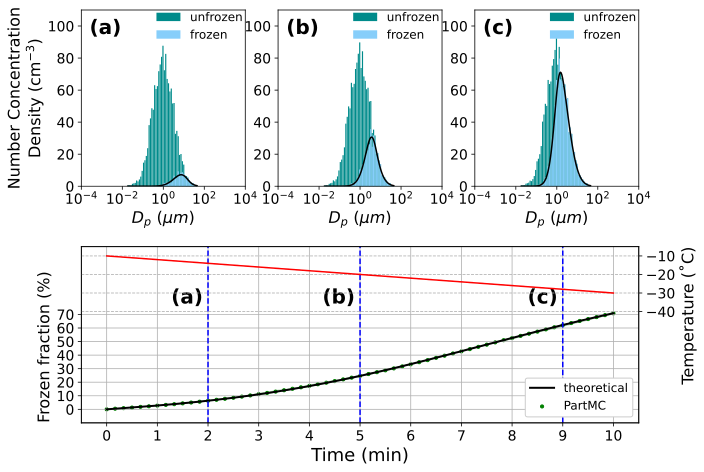

In [13]:
draw_figure7()

Figure 7. Comparison of model results from case `expName` in Table (2) with theoretical predictions. Upper panel: Snapshots of number concentration density distribution of unfrozen (green) and frozen droplets (blue) at specific times indicated by the blue dashed lines in the lower panel. The black solid line depicts the theoretical size distribution of activated INPs calculated using Eq. (B10). Lower panel: temperature profile (red line) and time evolution of frozen fraction from 20 realizations (green dots: the average; green shading: the minimum-maximum range), and the theoretical frozen fraction calculated using Eq. (B12) (black line).

# Plot Figure 8

In [14]:
def draw_panel_for_figure8(fig, ax, casesName, ax_label):
    
    cmap = plt.cm.Blues
    chi_list =  np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1])
    chi_colors = cmap(0.3 + 0.7 * chi_list)
    chi_colors = chi_colors[::-1]

    ylabel_fontsize = 15

    casesLabel = [
        "100% $Illite$",
        "100% $Fe_2O_3$",
        "Internal Mixture",
        "External Mixture"
    ]
    casesColor = ["green", "grey", chi_colors[0], chi_colors[-1]]

    sampleName = casesName[0]
    casesDict = {}

    for caseName in casesName:
        timeList = experiments_output[caseName]["time"][0, :]
        tempList = experiments_output[caseName]["temperature"][0, :]
        ice_ratio_mean = experiments_output[caseName]["frozen_frac"].mean(axis = 0)
        ice_ratio_max = experiments_output[caseName]["frozen_frac"].max(axis = 0)
        ice_ratio_min = experiments_output[caseName]["frozen_frac"].min(axis = 0)

        CaseDict = {
            "timeList": timeList,
            "tempList": tempList,
            "ice_ratio_mean": ice_ratio_mean,
            "ice_ratio_max": ice_ratio_max,
            "ice_ratio_min": ice_ratio_min
        }
        casesDict[caseName] = CaseDict

    timeList = casesDict[sampleName]["timeList"]
    timeList = timeList / 60
    temperature  = casesDict[sampleName]["tempList"]

    axt = ax.twinx()
    axt.plot(timeList, temperature - 273.15, color = "red")
    axt.set_yticks([-40, -30, -20, -10])
    axt.set_ylim([-102.5, -5])
    axt.grid(linestyle = "--")


    for ind, caseName in enumerate(casesName):
        ice_ratio_mean = casesDict[caseName]["ice_ratio_mean"]
        ice_ratio_max =  casesDict[caseName]["ice_ratio_max"]
        ice_ratio_min =  casesDict[caseName]["ice_ratio_min"]
        ax.plot(
            timeList, ice_ratio_mean * 100,
            label = casesLabel[ind], color = casesColor[ind], linewidth = 0.7
        )
        ax.fill_between(
            timeList, ice_ratio_min * 100, ice_ratio_max * 100,
            color = casesColor[ind], alpha = 0.3, edgecolor = None
        )

    ax.set_yticks([0, 20, 40, 60, 80])
    ax.set_ylim([-15, 140])
    ax.grid()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    for label in axt.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")
    axt.set_ylabel("Temperature (˚C)", loc = "top", fontsize = ylabel_fontsize)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")
    for label in ax.get_xticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")


    ax.set_ylabel("Frozen fraction (%)", loc = "bottom", fontsize = ylabel_fontsize)
    
    ax.text(
        -0.01, 0.96, ax_label,
        horizontalalignment = "right",
        verticalalignment = "top",
        transform = ax.transAxes,
        fontsize = 15
    )
    ax.legend(loc = "center left")
    return fig, ax

def draw_figure8():
    xlabel_fontsize = 15
    fig, axes = plt.subplots(2, 1, figsize = (10, 7), sharex = True)
    plt.subplots_adjust(hspace = 0.1)
    ax1, ax2 = axes[0], axes[1]
    casesName = ["exp1", "exp2", "exp3", "exp4"]
    fig, ax1 = draw_panel_for_figure8(fig, ax1, casesName, ax_label = "(a)")

    casesName = ["exp5", "exp6", "exp7", "exp8"]
    fig, ax2 = draw_panel_for_figure8(fig, ax2, casesName, ax_label = "(b)")
    ax2.set_xlabel("Time (min)", fontsize = xlabel_fontsize)

    show_plot("TSs")

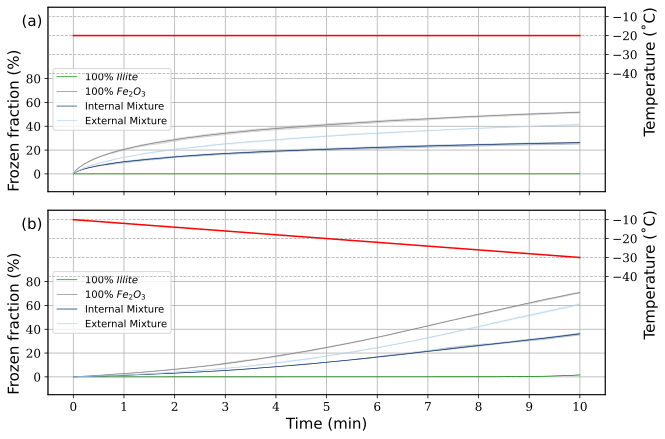

In [15]:
draw_figure8()

Figure 8: Simulated frozen fraction for Cases 1--8. (a) isothermal freezing conditions, Cases 1-4. (b) constant cooling rate freezing conditions, Cases 5--8. Solid lines represent the average frozen fraction from `n_ensemble` repeated simulations for each scenario, and the shaded areas denote the range between the maximum and minimum values.

# Plot Figure 9

In [16]:
def draw_figure9():
    
    cmap = plt.cm.Blues
    chi_colors = cmap(np.linspace(0.4, 1, 10))
    chi_colors = chi_colors[::-1]

    xlabel_size = 16
    ylabel_size = 16
    ytick_size = 13
    xtick_size = 13
    text_size1 = 14
    text_size2 = 12


    _, axes = plt.subplots(2, 4, figsize = (10, 5.3))

    for item in range(2):
        for ind in range(4):

            ax = axes[item][ind]
            exp_name = "exp%d" % (item * 4 + ind + 1)
            fice_model = experiments_output[exp_name]["frozen_frac"].mean(axis=0)
            fice_theo = theoretical_frozen_fraction_results[exp_name]
            ax.scatter(fice_model * 100, fice_theo * 100, s = 0.2, color = "black", zorder = 2)

            xlim1, xlim2 = ax.get_xlim()
            ylim1, ylim2 = ax.get_ylim()
            start_point = np.min([xlim1, ylim1])
            end_point = np.min([xlim2, ylim2])

            line_x = np.linspace(start_point, end_point, 1000)
            line_y = line_x.copy()
            ax.plot(line_x, line_y, color = "red", linewidth = 1, linestyle = "--", zorder = 1)

            ax.set_xlim([start_point, end_point])
            ax.set_yticks(ax.get_xticks())
            ax.set_ylim([start_point, end_point])

            for label in ax.get_yticklabels():
                label.set_fontsize(ytick_size)
            for label in ax.get_xticklabels():
                label.set_fontsize(xtick_size)

            if item == 1:
                ax.set_xlabel("PartMC $f_\\mathrm{frz}$ (%)", fontsize = xlabel_size)
                
            if ind == 0:
                ax.set_ylabel("Theoretical $f_\\mathrm{frz}$ (%)", fontsize = ylabel_size)
                
            ax.text(
                0.05, 0.95, "Case " + str(item * 4 + ind + 1),
                horizontalalignment = "left",
                verticalalignment = "top",
                transform = ax.transAxes,
                fontsize = text_size1
            )

            # Calculate the RMSE
            RMSE = np.sqrt(np.mean((fice_model * 100 - fice_theo * 100) **2))

            # Calculate the correlation coefficient
            if fice_model.max() < 1e-6:
                # If model results are all zero.
                CORR = np.nan
            else:
                CORR = np.corrcoef(fice_model, fice_theo)[0, 1]
            text_string = "$R_\\mathrm{MSE}$ = %.5f" % (RMSE)
            ax.text(
                0.99, 0.03, text_string,
                horizontalalignment = "right",
                verticalalignment = "bottom",
                transform = ax.transAxes,
                fontsize = text_size2
            )
            text_string = "$r$ = %.5f" % (CORR)
            ax.text(
                0.99, 0.10, text_string,
                horizontalalignment = "right",
                verticalalignment = "bottom",
                transform = ax.transAxes,
                fontsize = text_size2
            )
    show_plot("TS_comparison.pdf")

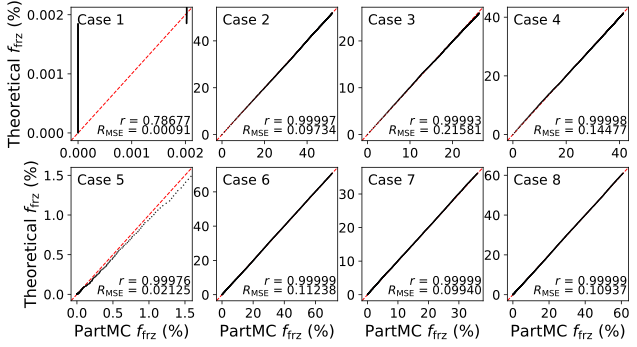

In [17]:
draw_figure9()

Figure 9. Simulated frozen fraction from an ensemble mean of `n_ensemble` repeated PartMC simulations and analytical results for the eight cases listed in Table 2 (Cases 1--8). Each plot corresponds to one case and depicts the average frozen fraction values from the simulations against the theoretical predictions. The red dashed line represents the 1:1 line between the simulated and theoretical values.

# Run PartMC simulations initiated by different mixing state from $\chi$ = 10\% to $\chi$ = 90\%

In [18]:
def set_mixing_state_for_bins(target_chi, aero_state, aero_data, Nbins):
    
    species_volume, exc_H2O_ind = get_species_volume(aero_state, aero_data)
    index_dict = binned_by_log10Vp(species_volume, Nbins = Nbins)
    species_volume = set_chi_for_bins(
        species_volume,
        target_chi,
        index_dict,
    )
    
    Npart = len(aero_state)
    for i_part in range(Npart):
        sut = aero_state.particle(i_part)
        volumes = sut.volumes
        for ind, i_spec in enumerate(exc_H2O_ind):
            volumes[i_spec] = species_volume[ind, i_part]
        
        sut.set_vols(volumes)
        aero_state.add_particle(sut)
        aero_state.remove_particle(i_part)
    return aero_state, species_volume
    
        
def get_species_volume(aero_state, aero_data):

    Npart = len(aero_state)
    Ns = len(aero_data)

    try:
        H2O_ind = aero_data.spec_by_name("H2O")
    except RuntimeError:
        H2O_ind = None

    exc_H2O_ind = []
    for ind in range(Ns):
        if ind != H2O_ind:
            exc_H2O_ind.append(ind)
    Ns_dry = len(exc_H2O_ind)
    species_volume = np.full( (Ns_dry, Npart), np.nan )
    for i_part in range(Npart):
        for ind, i_spec in enumerate(exc_H2O_ind):
            species_volume[ind, i_part] = aero_state.particle(i_part).volumes[i_spec]
    return species_volume, exc_H2O_ind

def binned_by_log10Vp(species_volume, Nbins):
    
    Npart = species_volume.shape[1]
    if Nbins == 1:
        
        index_dict = {0: np.arange(Npart)}
        return index_dict

    Vp_core = np.sum(species_volume, axis = 0)
    log10_Vp_core = np.log10(Vp_core)
    _, bin_edges = np.histogram(log10_Vp_core, bins = Nbins)
    index_dict = {}
    for ind, (edge1, edge2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        if ind == 0:
            choosed_ind = np.where( (log10_Vp_core >= edge1) & (log10_Vp_core <= edge2) )[0]
        else:
            choosed_ind = np.where( (log10_Vp_core > edge1) & (log10_Vp_core <= edge2) )[0]
        index_dict[ind] = choosed_ind.copy()
    return index_dict

def set_chi_for_bins(species_volume, target_chi, index_dict):
    
    for _, part_index in index_dict.items():
        if len(part_index) < 2:
            continue
        species_volume_ibin = set_chi(species_volume[:, part_index], target_chi)
        species_volume[:, part_index] = species_volume_ibin

    return species_volume

def init_external(species_total_volume_ratio, Vp_core, Ns, Npart):
    
    species_volume_ratio = np.full((Ns, Npart), 0.0)
    species_total_volume_ratio = species_total_volume_ratio \
        / np.sum(species_total_volume_ratio)
    aero_ind = np.arange(Npart)
    np.random.shuffle(aero_ind)
    species_volume_cumsum = np.cumsum(Vp_core[aero_ind])
    species_volume_cumratio = species_volume_cumsum / species_volume_cumsum[-1]
    threshold_ratio = np.cumsum(species_total_volume_ratio)
    threshold = [0]
    for ratio in threshold_ratio:
        if ratio == 0:
            threshold.append(0)
        else:
            threshold.append(np.argmin(np.abs(species_volume_cumratio - ratio)) + 1)
    for i_spec in range(Ns):
        spec_index = aero_ind[threshold[i_spec]:threshold[i_spec+1]]
        species_volume_ratio[i_spec, spec_index] = 1.0
    species_volume = species_volume_ratio * Vp_core

    return species_volume

def run_RVE(species_volume, target_chi, Npars):
    # The Random Volume Exchange algorithm.
    # It is equivalent to the Random Surface Exchange algorithm (Algorithm G1 in the paper)
    # when applied to monodisperse INPs or to INPs within the same bin
    # under the assumption that volume ratio = surface ratio.

    Ns, Npart = species_volume.shape
    volume_ratio = np.sum(species_volume, axis=1) / np.sum(species_volume)
    Vp_core = species_volume.sum(axis = 0)
    species_volume = init_external(volume_ratio, Vp_core,  Ns, Npart)
    while True:
        species_volume = RVE(species_volume, Npars = Npars)
        chi = compute_chi(species_volume)
        if target_chi <= chi:
            break
    return species_volume


def RVE(species_volume, Npars):

    Npart = species_volume.shape[1]
    assert Npars * 2 <= Npart
    Vp_core = species_volume.sum(axis = 0)
    species_volume_ratio = species_volume / Vp_core

    aero_index = np.arange(Npart)
    np.random.shuffle(aero_index)
    parA_ind = aero_index[:Npars]
    parB_ind = aero_index[-Npars:]
    parA_vol = Vp_core[parA_ind]
    parB_vol = Vp_core[parB_ind]
    min_vol = np.min(np.array([parA_vol, parB_vol]), axis = 0)
    exchange_ratio = np.random.rand(len(min_vol)) 
    exchange_vol = exchange_ratio * min_vol
    exchange_species_vol_A = species_volume_ratio[:, parA_ind] * exchange_vol
    exchange_species_vol_B = species_volume_ratio[:, parB_ind] * exchange_vol
    species_volume[:, parB_ind] = \
        species_volume[:, parB_ind] - exchange_species_vol_B + exchange_species_vol_A
    species_volume[:, parA_ind] = \
        species_volume[:, parA_ind] - exchange_species_vol_A + exchange_species_vol_B

    return species_volume

def set_chi(species_volume, target_chi):

    count = 0
    max_count = 200
    best_species_volume = None
    best_chi = None
    min_diff = np.inf
    diff_tol = 0.01
    while True:
        count += 1
        species_volume = run_RVE(species_volume, target_chi = target_chi, Npars = 1)
        current_chi = compute_chi(species_volume)
        diff = np.abs(current_chi - target_chi)
        if diff < min_diff:
            min_diff = diff
            best_species_volume = species_volume.copy()
            best_chi = compute_chi(best_species_volume)
        if diff < diff_tol:
            break
        if count >= max_count:
            break
    assert np.abs(best_chi - target_chi) == min_diff
    return best_species_volume


def compute_chi(species_volume):
    
    Vp = species_volume.sum(axis = 0)
    species_total_volume = species_volume.sum(axis = 1)
    P_ai = species_volume / Vp
    P_i = Vp / Vp.sum()
    P_a = species_total_volume / Vp.sum()

    # Here we define 0*log(0) = 1*log(1) = 0.
    # Modify P_ai, P_a to avoid log(0) occurs in computation.
    P_ai = np.where(P_ai == 0.0, 1.0, P_ai)
    P_a = np.where(P_a == 0.0, 1.0, P_a) 
    
    Hi = -np.sum(P_ai * np.log(P_ai), axis = 0)
    Ha = np.sum(P_i * Hi)
    Hy = -np.sum(P_a * np.log(P_a))
    Da = np.exp(Ha)
    Dy = np.exp(Hy)
    chi = (Da - 1) / (Dy - 1)

    return chi

def show_chi_bins(species_volume, index_dict):
    
    for ibin, part_index in index_dict:
        if len(part_index) == 0:
            print("bin #", ibin, ": no particle")
        else:
            chi_ibin = compute_chi(species_volume[:, part_index])
            print("bin #", ibin, ": N_parts = ", len(part_index), "; chi = ", chi_ibin)
            
class MixingStateModifier():
    
    """ Mixing state modifier for INPs.

    Sets the mixing state of INPs in each size bin with a target χ 
    (`target_chi`) and a specified number of bins (`Nbins`). 
    Use `modify(aero_state, aero_data)` to return the modified `aero_state`.
    """
    
    def __init__(self, target_chi, Nbins):
        self.target_chi = target_chi
        self.Nbins = Nbins
        
    def modify(self, aero_state, aero_data):
        return set_mixing_state_for_bins(
            target_chi = self.target_chi,
            aero_state = aero_state,
            aero_data = aero_data,
            Nbins = self.Nbins
        )

In [19]:
# Conduct experiments initialized with INPs whose χ ranges from 10% to 90%.
target_chi_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Divide particles into `Nbins_for_chi_setting`, and set χ=`chi` for each bin.
Nbins_for_chi_setting = 50

for cooling_name in ["constT", "cooling"]:
    setName = "exp4" if cooling_name == "constT" else "exp8"
    for chi_to_set in target_chi_list:
        case_name = cooling_name + "_chi=%.2f" % (chi_to_set) 
        print("Running PartMC for " + case_name + " ...")
        obj_mixing_state_modifier = MixingStateModifier(
            target_chi = chi_to_set,
            Nbins = Nbins_for_chi_setting
        )
        experiments_output[case_name] = run_experiment_ensemble(
            N_PART = 5000,
            n_ensemble = 10,
            weight_type = "flat", # Must set to "flat"
            mixing_state_modifier = obj_mixing_state_modifier,
            **exps_settings_PartMC[setName]
        )

Running PartMC for constT_chi=0.10 ...
Running PartMC for constT_chi=0.20 ...
Running PartMC for constT_chi=0.30 ...
Running PartMC for constT_chi=0.40 ...
Running PartMC for constT_chi=0.50 ...
Running PartMC for constT_chi=0.60 ...
Running PartMC for constT_chi=0.70 ...
Running PartMC for constT_chi=0.80 ...
Running PartMC for constT_chi=0.90 ...
Running PartMC for cooling_chi=0.10 ...
Running PartMC for cooling_chi=0.20 ...
Running PartMC for cooling_chi=0.30 ...
Running PartMC for cooling_chi=0.40 ...
Running PartMC for cooling_chi=0.50 ...
Running PartMC for cooling_chi=0.60 ...
Running PartMC for cooling_chi=0.70 ...
Running PartMC for cooling_chi=0.80 ...
Running PartMC for cooling_chi=0.90 ...


# Plot Figure 12

In [20]:
def xvar_draw(fig, ax, coolingName, chi_list, mark_label = None):
    
    cmap = plt.cm.Blues
    casesColor = cmap(np.linspace(0.4, 1, 11))
    casesColor = casesColor[::-1]
    
    tick_fontsize = 20
    label_fontsize = 22
    chi_label_font = 13
    casesLabel = ["$\\chi$=%d%%" % (int(chi * 100)) for chi in chi_list]
        
    lines = []
    labels = []
    last_x = []
    last_y = []
    for ind, chi in enumerate(chi_list):
        if chi == 0.0:
            key = "exp3" if coolingName == "constT" else "exp7"
        elif chi == 1.0:
            key = "exp4" if coolingName == "constT" else "exp8"
        else:
            key = coolingName + "_chi=%.2f" % (chi)
        timeList = experiments_output[key]["time"][0]
        ff = experiments_output[key]["frozen_frac"].mean(axis=0)

        line, = ax.plot(
            timeList/60, ff * 100,
            label = casesLabel[ind],
            color = casesColor[ind],
            linewidth = 0.7
        )
        lines.append(line)
        labels.append(line.get_label())
        last_x.append(timeList[-1]/60)
        last_y.append(ff[-1] * 100)
    
    last_x = np.array(last_x)
    last_y = np.array(last_y)
    for label in ax.get_yticklabels():
        label.set_fontsize(tick_fontsize)
    for label in ax.get_xticklabels():
        label.set_fontsize(tick_fontsize)
    
    for ind, (x, y) in enumerate(zip(last_x, last_y)):
        if ind % 2  == 0:
            continue
        x_offset = 0.1
        y_offset = 0

        horizontalalignment = "left"
        verticalalignment = "center"
        ax.text(
            x + x_offset, y + y_offset, casesLabel[ind],
            fontweight = 1000,
            horizontalalignment = horizontalalignment,
            verticalalignment = verticalalignment,
            color = casesColor[ind],
            fontsize = chi_label_font
        )

    ax.grid()
    ax.set_xlim([0, 11.5])
    if coolingName == "constT":
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([0, 70])
    ax.set_ylabel("Frozen fraction (%)", fontsize = label_fontsize)
    for label in ax.get_yticklabels():
        label.set_fontsize(tick_fontsize)
    for label in ax.get_xticklabels():
        label.set_fontsize(tick_fontsize)
    if not(mark_label) is None:
        ax.text(
            0.02, 0.95, mark_label,
            horizontalalignment = "left",
            verticalalignment = "top",
            transform = ax.transAxes,
            fontsize = 20,
            fontweight = "bold"
        )
    
    return fig, ax

In [21]:
def draw_figure12():
    label_fontsize = 22
    chi_list = [0.0] + target_chi_list + [1.0]
    fig = plt.figure(figsize = (8, 11))
    ax1 = fig.add_subplot(2, 1, 1)
    fig, ax1 = xvar_draw(fig, ax1, "constT", chi_list, mark_label = "(a)")
    ax2 = fig.add_subplot(2, 1, 2)
    fig, ax2 = xvar_draw(fig, ax2, "cooling", chi_list, mark_label = "(b)")
    ax2.set_xlabel("Time (min)", fontsize = label_fontsize)
    show_plot("xvar_bin_chis.pdf")

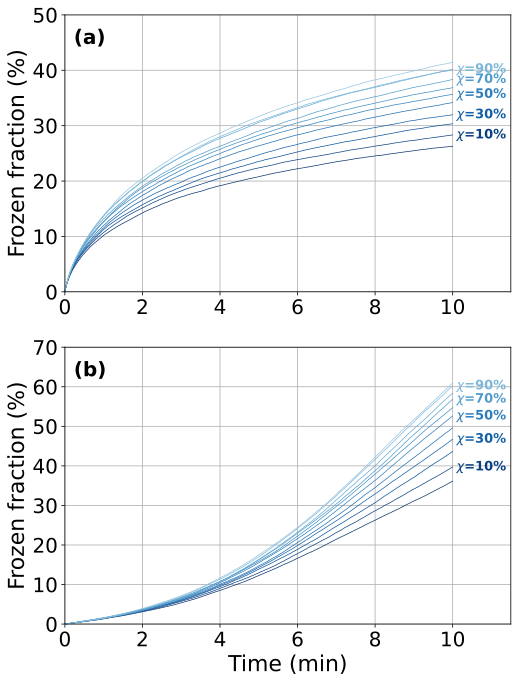

In [22]:
draw_figure12()

Figure 12. Time series of frozen fraction for immersed INPs with specific mixing state under a (a): isothermal freezing conditions with -20 ˚C and (b): constant cooling rate freezing conditions from -10 ˚C to -30 ˚C within 10 minutes. Each line corresponds to a specific mixing state of INPs, identified by varying values of the mixing state index $\chi$, which ranges from 0\% (purely external mixture) to 100\% (purely internal mixture).